In [24]:
# KÜTÜPHANELER
import os
import random
import shutil
import csv
from PIL import Image
import cv2  

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision.models import efficientnet_b1, EfficientNet_B1_Weights 

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)
from sklearn.preprocessing import label_binarize


In [25]:
#DİZİN AYARI
try:
    os.chdir(r"C:\Users\Eda EROL\OneDrive\veriset")
    print("Yeni Dizin:", os.getcwd())
except FileNotFoundError:
    print("HATA: Belirtilen dizin bulunamadı.")

Yeni Dizin: C:\Users\Eda EROL\OneDrive\veriset


In [26]:
#GÖRÜNTÜLERİ TEK KLASÖRE TOPLAMA
src_dirs = ["HAM10000_images_part_1", "HAM10000_images_part_2"]
dst_dir = "all_images"
os.makedirs(dst_dir, exist_ok=True)

In [27]:
for folder in src_dirs:
    folder_path = os.path.join(os.getcwd(), folder)
    for file in os.listdir(folder_path):
        src_path = os.path.join(folder_path, file)
        dst_path = os.path.join(dst_dir, file)
        if not os.path.exists(dst_path):
            shutil.copy(src_path, dst_path)

In [28]:
print(f"Tüm görüntüler '{dst_dir}' klasöründe toplandı. Toplam: {len(os.listdir(dst_dir))} dosya")

Tüm görüntüler 'all_images' klasöründe toplandı. Toplam: 10015 dosya


In [29]:
#METADATA YÜKLEME
metadata_file = "HAM10000_metadata.csv"
metadata = []

In [30]:
with open(metadata_file, newline="", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        metadata.append(row)

In [31]:
print(f"Metadata yüklendi. Toplam satır: {len(metadata)}")

Metadata yüklendi. Toplam satır: 10015


In [32]:
#METADATA'YI DATAFRAME'E ÇEVİR
df = pd.read_csv(r"C:\Users\Eda EROL\OneDrive\veriset\HAM10000_metadata.csv")

In [33]:
#SINIF DAĞILIMI
class_counts = df["dx"].value_counts()

In [34]:
#SINIF ETİKETLERİNİN SAYISAL OLARAK TANIMLANMASI
label_map = {
    "akiec": 0,  
    "bcc": 1,     
    "bkl": 2,     
    "df": 3,      
    "mel": 4,    
    "nv": 5,      
    "vasc": 6     
}

In [35]:
#METADATA'DAN ETİKETLERİ SAYISAL OLARAK AL
labels = np.array([label_map[item["dx"]] for item in metadata])

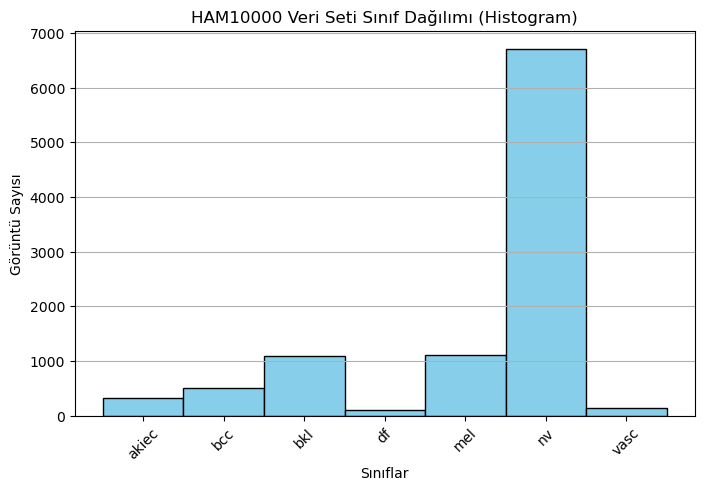

In [36]:
#HİSTOGRAM
plt.figure(figsize=(8,5))
plt.hist(labels, bins=np.arange(len(label_map)+1)-0.5, color='skyblue', edgecolor='black')
plt.xticks(range(len(label_map)), label_map.keys(), rotation=45)
plt.xlabel("Sınıflar")
plt.ylabel("Görüntü Sayısı")
plt.title("HAM10000 Veri Seti Sınıf Dağılımı (Histogram)")
plt.grid(axis="y")
plt.show()

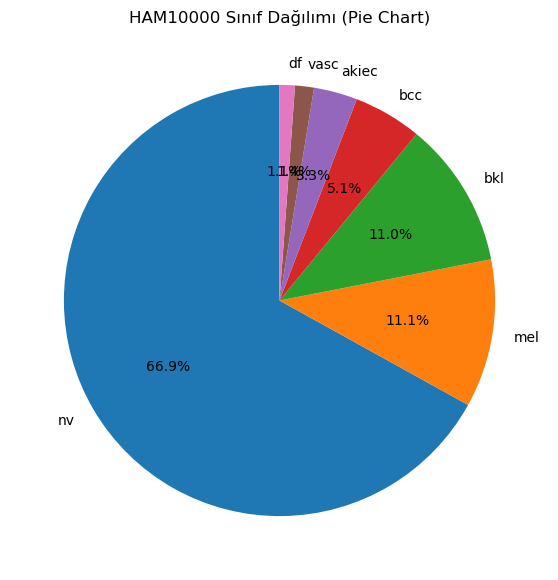

In [37]:
#PİE CHART
plt.figure(figsize=(7,7))
class_counts.plot(kind="pie", autopct="%1.1f%%", startangle=90)
plt.title("HAM10000 Sınıf Dağılımı (Pie Chart)")
plt.ylabel("")
plt.show()

In [38]:
#ETİKETLEME
label_map = { "akiec":0, "bcc":1, "bkl":2, "df":3, "mel":4, "nv":5, "vasc":6 }
data_list = []


In [39]:
for item in metadata:
    img_id = item["image_id"]
    label = label_map[item["dx"]]
    img_path = os.path.join(dst_dir, img_id + ".jpg")
    if os.path.exists(img_path):
        data_list.append((img_path, label))


In [40]:
print(f"Toplam kullanılabilir veri: {len(data_list)}")

Toplam kullanılabilir veri: 10015


In [41]:
#STRATIFIED K-FOLD İLE TRAIN/VALIDATION/TEST VERİ BÖLME
paths  = [x[0] for x in data_list]
labels = [x[1] for x in data_list]

In [42]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [43]:
for train_idx, test_idx in skf.split(paths, labels):
    train_paths  = [paths[i] for i in train_idx]
    train_labels = [labels[i] for i in train_idx]
    test_paths   = [paths[i] for i in test_idx]
    test_labels  = [labels[i] for i in test_idx]
    break

In [44]:
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths,
    train_labels,
    test_size=0.15,
    stratify=train_labels,
    random_state=42
)

In [45]:
train_list = list(zip(train_paths, train_labels))
val_list   = list(zip(val_paths, val_labels))
test_list  = list(zip(test_paths, test_labels))


In [46]:
#MODEL GİRDİSİ İÇİN GÖRÜNTÜ BOYUTU (128x128)
IMG_SIZE = 128

In [47]:
#TRAIN DATA TRANSFORMLARI
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [48]:
#VAL/TEST DATA TRANSFORMLARI
val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [49]:
#CİLT LEZYONU GÖRÜNTÜLERİ İÇİN CUSTOM DATASET
class SkinDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform
    def __len__(self):
        return len(self.data_list)
    def __getitem__(self, idx):
        img_path, label = self.data_list[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [50]:
#TRAIN/VALIDATION/TEST DATASET OLUŞTURMA
train_dataset = SkinDataset(train_list, transform=train_transform)
val_dataset = SkinDataset(val_list, transform=val_test_transform)
test_dataset = SkinDataset(test_list, transform=val_test_transform)

In [51]:
#TRAIN/VALIDATION/TEST DATALOADER OLUŞTURMA
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [93]:
print("DataLoader hazır!")

DataLoader hazır!


In [94]:
#MODELİN ÇALIŞACAĞI CİHAZ SEÇİMİ
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [95]:
#EFFICIENTNET-B1 MODEL TANIMLAMA
weights = EfficientNet_B1_Weights.DEFAULT
model = efficientnet_b1(weights=weights)


In [96]:
#SON KATMANI HAM10000 İÇİN 7 SINIFA UYARLAMA
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 7)


In [97]:
#MODELİN SEÇİLEN CİHAZA AKTARILMASI
model = model.to(device)

In [98]:
#LOSS VE OPTIMIZER AYARLARI
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [99]:
#EĞİTİM PARAMETRELERİ VE EARLY STOPPING DEĞİŞKENLERİ
num_epochs = 10
train_losses, val_losses = [],[]
train_accs, val_accuracies = [],[]
best_val_loss = np.inf
counter = 0
patience = 5

In [100]:
for epoch in range(num_epochs):
    #TRAIN(EĞİTİM)
    model.train()
    running_loss = 0
    total, correct = 0,0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    #VALIDATION(DOĞRULAMA)
    model.eval()
    val_loss = 0
    total, correct = 0,0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    val_loss = val_loss / total
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    #VALIDATION LOSS’A GÖRE EARLY STOPPING
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model_wts = model.state_dict()  # en iyi model kaydı
    else:
        counter += 1
        if counter >= patience:
            model.load_state_dict(best_model_wts)
            print(f"Early stopping at epoch {epoch+1}")
            break

    #EPOCH SONUÇLARININ GÖSTERİMİ
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1/10 | Train Loss: 1.1149, Train Acc: 0.6643 | Val Loss: 0.7179, Val Acc: 0.7496
Epoch 2/10 | Train Loss: 0.6431, Train Acc: 0.7759 | Val Loss: 0.5560, Val Acc: 0.8103
Epoch 3/10 | Train Loss: 0.5222, Train Acc: 0.8188 | Val Loss: 0.4976, Val Acc: 0.8111
Epoch 4/10 | Train Loss: 0.4619, Train Acc: 0.8341 | Val Loss: 0.4496, Val Acc: 0.8378
Epoch 5/10 | Train Loss: 0.4073, Train Acc: 0.8552 | Val Loss: 0.4386, Val Acc: 0.8403
Epoch 6/10 | Train Loss: 0.3510, Train Acc: 0.8759 | Val Loss: 0.4184, Val Acc: 0.8494
Epoch 7/10 | Train Loss: 0.3082, Train Acc: 0.8903 | Val Loss: 0.4195, Val Acc: 0.8469
Epoch 8/10 | Train Loss: 0.2752, Train Acc: 0.9000 | Val Loss: 0.4126, Val Acc: 0.8594
Epoch 9/10 | Train Loss: 0.2467, Train Acc: 0.9115 | Val Loss: 0.4137, Val Acc: 0.8527
Epoch 10/10 | Train Loss: 0.2247, Train Acc: 0.9192 | Val Loss: 0.4120, Val Acc: 0.8619


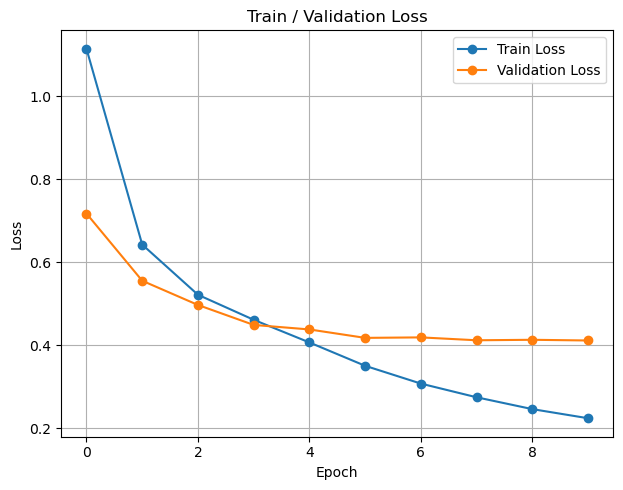

In [111]:
#TRAIN VE VALIDATION LOSS GRAFİĞİNİN OLUŞTURULMASI VE GÖSTERİLMESİ
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train / Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


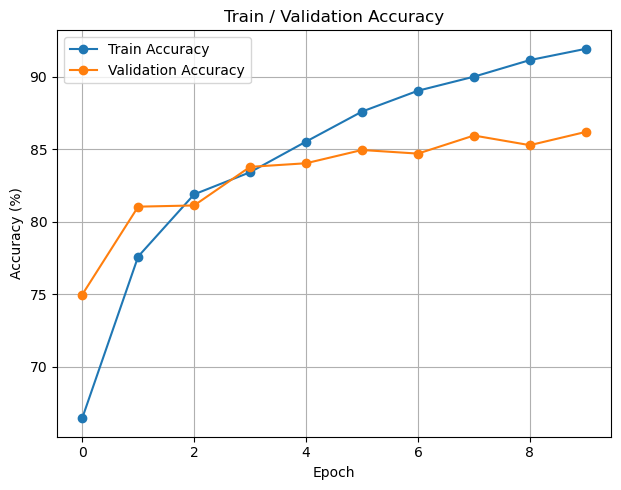

In [112]:
#TRAIN VE VALIDATION ACCURACY GRAFİĞİNİN OLUŞTURULMASI VE GÖSTERİLMESİ
plt.figure(figsize=(12,5))
plt.subplot(1,2,2)
plt.plot([a*100 for a in train_accs], label='Train Accuracy', marker='o')
plt.plot([a*100 for a in val_accuracies], label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train / Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [113]:
#TEST VERİ SETİ ÜZERİNDE DOĞRULUK HESAPLAMA VE YAZDIRMA
test_accuracy = correct / total

In [115]:
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.8619


In [116]:
#TÜM FEATURE KATMANLARINI FINE-TUNING İÇİN AÇMA
for param in model.parameters():
    param.requires_grad = True

In [118]:
#FINE-TUNING İÇİN FEATURE VE CLASSIFIER KATMANLARI FARKLI LEARNING RATE İLE OPTİMİZE ETME
optimizer = optim.Adam([
    {'params': model.features.parameters(), 'lr': 1e-4},  #backbone katmanı için küçük learning rate
    {'params': model.classifier.parameters(), 'lr': 1e-3} #classifier katmanı için daha yüksek learning rate
])

In [119]:
#EĞİTİM PARAMETRELERİ VE EARLY STOPPING AYARLARI
num_epochs = 10
patience = 5
best_val_loss = np.inf
counter = 0

In [120]:
#EĞİTİM VE DOĞRULAMA KAYIP VE DOĞRULUK DEĞERLERİNİN TAKİBİ
train_losses, val_losses = [],[]
train_accs, val_accuracies = [],[]


In [121]:
#FINE-TUNING EĞİTİM DÖNGÜSÜ:TRAIN,VALIDATION VE EARLY STOPPING
for epoch in range(num_epochs):
    #TRAINING AŞAMASI:MODELİN EĞİTİLMESİ VE TRAIN LOSS/ACCURACY HESAPLAMA
    model.train()
    running_loss = 0
    total, correct = 0,0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    #VALIDATION AŞAMASI:MODELİN DOĞRULAMA VERİSİ ÜZERİNDE TEST EDİLMESİ VE LOSS/ACCURACY HESAPLAMA
    model.eval()
    val_loss = 0
    total, correct = 0,0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    val_loss = val_loss / total
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    #EARLY STOPPING:EN İYİ MODELİ KAYDETME VE PATIENCE SINIRINI KONTROL ETME
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model_wts = model.state_dict()
    else:
        counter += 1
        if counter >= patience:
            model.load_state_dict(best_model_wts)
            print(f"Early stopping at epoch {epoch+1}")
            break

    #EPOCH SONU METRİKLERİNİN YAZDIRILMASI(TRAIN/VAL LOSS VE ACC)
    print(f"[Fine-Tuning] Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


[Fine-Tuning] Epoch 1/10 | Train Loss: 0.1941, Train Acc: 0.9269 | Val Loss: 0.4504, Val Acc: 0.8577
[Fine-Tuning] Epoch 2/10 | Train Loss: 0.1690, Train Acc: 0.9401 | Val Loss: 0.4529, Val Acc: 0.8561
[Fine-Tuning] Epoch 3/10 | Train Loss: 0.1551, Train Acc: 0.9433 | Val Loss: 0.4745, Val Acc: 0.8661
[Fine-Tuning] Epoch 4/10 | Train Loss: 0.1418, Train Acc: 0.9477 | Val Loss: 0.4846, Val Acc: 0.8478
[Fine-Tuning] Epoch 5/10 | Train Loss: 0.1277, Train Acc: 0.9535 | Val Loss: 0.4610, Val Acc: 0.8602
Early stopping at epoch 6


In [128]:
#FİNAL TEST:MODELİN TEST VERİ SETİ ÜZERİNDE DEĞERLENDİRİLMESİ VE DOĞRULUK HESAPLAMA
model.eval()
all_preds, all_labels = [], []


In [130]:
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [131]:
test_correct = np.sum(np.array(all_preds) == np.array(all_labels))
test_total = len(all_labels)
test_acc = test_correct / test_total

In [132]:
print(f"[Fine-Tuning] Test Accuracy: {test_acc:.4f}")

[Fine-Tuning] Test Accuracy: 0.8622


In [143]:
#SINIF İNDEKSLERİNİN İSİMLERLE EŞLEŞTİRİLMESİ
idx_to_class = {
    0: "akiec",
    1: "bcc",
    2: "bkl",
    3: "df",
    4: "mel",
    5: "nv",
    6: "vasc"
}

In [144]:
#CONFUSION MATRIX HESAPLAMA
cm = confusion_matrix(all_labels, all_preds)

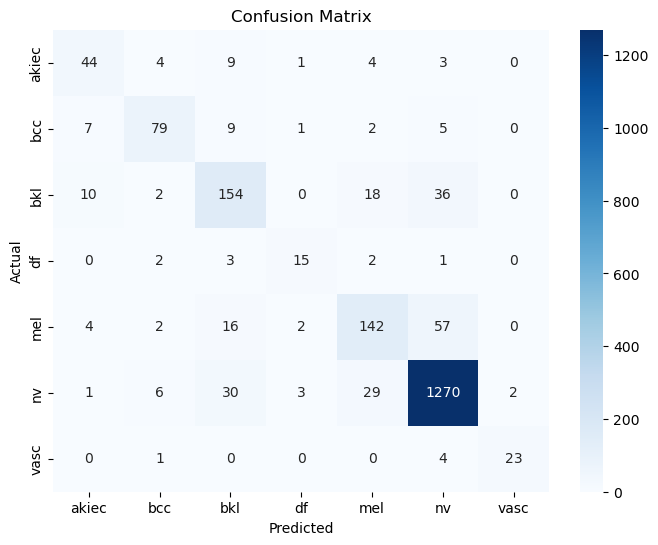

In [292]:
#CONFUSION MATRIX GRAFİĞİNİ ÇİZME VE GÖRSELLEŞTİRME
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[idx_to_class[i] for i in range(7)],
            yticklabels=[idx_to_class[i] for i in range(7)])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [148]:
#SINIFLAR İÇİN PRECISION, RECALL, F1-SCORE VE SUPPORT HESAPLAMA
report = classification_report(
    all_labels, all_preds,
    target_names=[idx_to_class[i] for i in range(7)]
)

In [149]:
#CLASSIFICATION REPORT’UN YAZDIRILMASI
print(report)

              precision    recall  f1-score   support

       akiec       0.67      0.68      0.67        65
         bcc       0.82      0.77      0.79       103
         bkl       0.70      0.70      0.70       220
          df       0.68      0.65      0.67        23
         mel       0.72      0.64      0.68       223
          nv       0.92      0.95      0.93      1341
        vasc       0.92      0.82      0.87        28

    accuracy                           0.86      2003
   macro avg       0.78      0.74      0.76      2003
weighted avg       0.86      0.86      0.86      2003



In [161]:
#HAM10000 VERİ SETİNDEKİ SINIF SAYISI
n_classes = 7

In [162]:
#ETİKETLERİ ONE-HOT ENCODE ETME VE SKOR MATRİSİ HAZIRLAMA
y_true = label_binarize(all_labels, classes=range(n_classes))
y_score = np.zeros_like(y_true)


In [164]:
#TEST SETİ ÜZERİNDEN MODEL ÇIKTILARINI SOFTMAX SKORLARINA ÇEVİRME
model.eval()
with torch.no_grad():
    all_probs = []
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())
    y_score = np.vstack(all_probs)

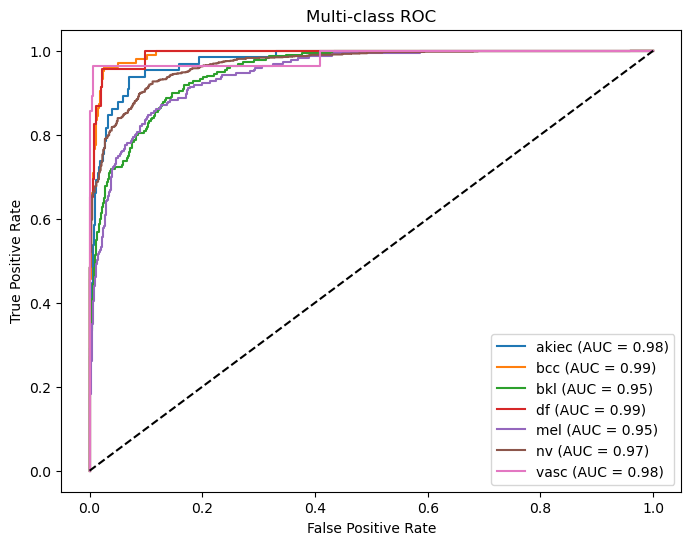

In [165]:
#MULTI-CLASS ROC GRAFİĞİ ÇİZME VE AUC DEĞERLERİNİ GÖSTERME
plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{idx_to_class[i]} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC")
plt.legend(loc="lower right")
plt.show()

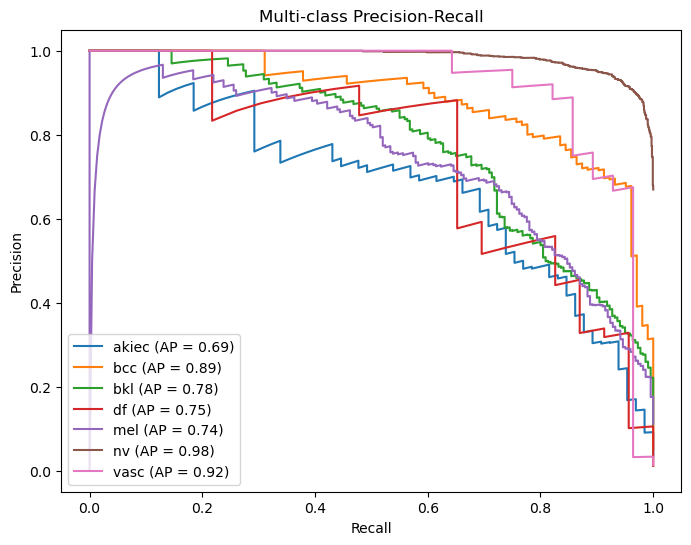

In [166]:
#MULTI-CLASS PRECISION-RECALL GRAFİĞİ ÇİZME VE AP DEĞERLERİNİ GÖSTERME
plt.figure(figsize=(8,6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_score[:, i])
    ap = average_precision_score(y_true[:, i], y_score[:, i])
    plt.plot(recall, precision, label=f"{idx_to_class[i]} (AP = {ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Multi-class Precision-Recall")
plt.legend(loc="lower left")
plt.show()

In [212]:
#KANSER SINIFLARI(MALIGNANT LEZYONLAR)
#Kanser sınıfları: akiec=0, bcc=1, df=3, mel=4
cancer_classes = [0, 1, 3, 4]

In [213]:
#KANSER SINIFLARI İÇİN TRUE VE SCORE DEĞERLERİNİ TUTMA
y_true_cancer = []
y_score_cancer = []

In [214]:
#KANSER SINIFLARI İÇİN TRUE DEĞERLERİ VE SCORELARI HESAPLAMA
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        
        for i in range(labels.size(0)):
            label = labels[i].item()
            y_true_cancer.append(1 if label in cancer_classes else 0)
            #Kanser olma olasılığı=seçili kanser sınıflarının olasılıklarının toplamı
            y_score_cancer.append(probs[i, cancer_classes].sum().item())


In [215]:
#KANSER SINIFLARI İÇİN TRUE VE SCORE LİSTELERİNİ NUMPY ARRAY’E ÇEVİRME
y_true_cancer = np.array(y_true_cancer)
y_score_cancer = np.array(y_score_cancer)

In [216]:
#KANSER DIŞI SINIFLAR İÇİN TRUE VE SCORE LİSTELERİNİ OLUŞTURMA
y_true_non_cancer = 1 - y_true_cancer
y_score_non_cancer = 1 - y_score_cancer

In [217]:
#KANSER SINIFLARI İÇİN ROC EĞRİSİ VE AUC HESAPLAMA
fpr_c, tpr_c, _ = roc_curve(y_true_cancer, y_score_cancer)
roc_auc_c = auc(fpr_c, tpr_c)

In [218]:
#KANSER DIŞI SINIFLAR İÇİN ROC EĞRİSİ VE AUC HESAPLAMA
fpr_nc, tpr_nc, _ = roc_curve(y_true_non_cancer, y_score_non_cancer)
roc_auc_nc = auc(fpr_nc, tpr_nc)

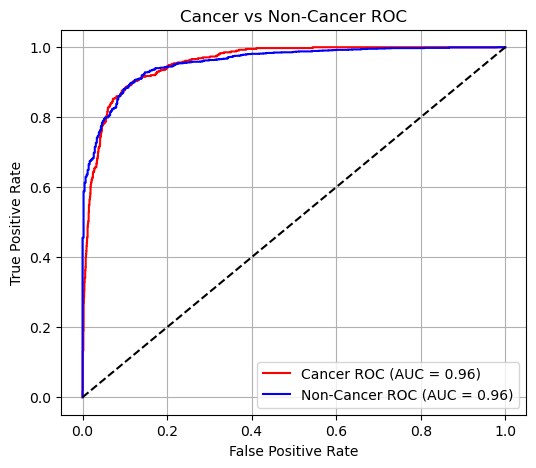

In [219]:
#KANSER VE KANSER DIŞI SINIFLAR İÇİN ROC GRAFİĞİ ÇİZME
plt.figure(figsize=(6,5))
plt.plot(fpr_c, tpr_c, label=f"Cancer ROC (AUC = {roc_auc_c:.2f})", color="red")
plt.plot(fpr_nc, tpr_nc, label=f"Non-Cancer ROC (AUC = {roc_auc_nc:.2f})", color="blue")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Cancer vs Non-Cancer ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [224]:
#KANSER SINIFLARI İÇİN PRECISION-RECALL VE AP HESAPLAMA
precision_c, recall_c, _ = precision_recall_curve(y_true_cancer, y_score_cancer)
ap_c = average_precision_score(y_true_cancer, y_score_cancer)


In [225]:
#KANSER DIŞI SINIFLAR İÇİN PRECISION-RECALL VE AP HESAPLAMA
precision_nc, recall_nc, _ = precision_recall_curve(y_true_non_cancer, y_score_non_cancer)
ap_nc = average_precision_score(y_true_non_cancer, y_score_non_cancer)

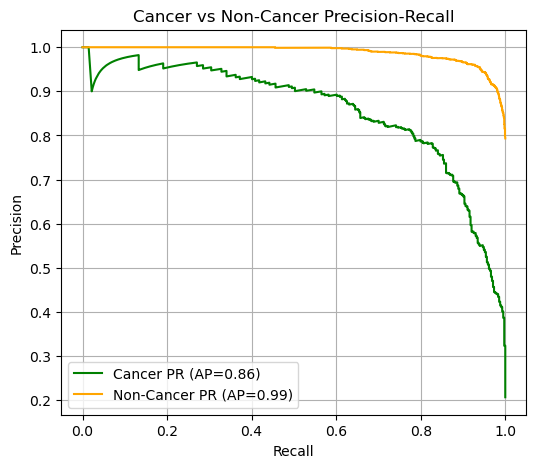

In [226]:
#KANSER VE KANSER DIŞI SINIFLAR İÇİN PRECISION-RECALL GRAFİĞİ ÇİZME
plt.figure(figsize=(6,5))
plt.plot(recall_c, precision_c, label=f"Cancer PR (AP={ap_c:.2f})", color="green")
plt.plot(recall_nc, precision_nc, label=f"Non-Cancer PR (AP={ap_nc:.2f})", color="orange")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Cancer vs Non-Cancer Precision-Recall")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


In [355]:
#TEST SETİNDEN ORTADAN 4 ÖRNEK SEÇME
mid_idx = len(test_dataset) // 2
middle_4_samples = list(test_dataset.data_list)[mid_idx-2 : mid_idx+2]

In [356]:
#KLİNİK SINIFLARIN TANIMLANMASI:KANSER,ÖNCÜ KANSER,BENİGN
cancer_classes = [0, 1, 3, 4]
pre_cancer_classes = [2]
benign_classes = [5, 6]

In [357]:
#ETİKETİ KLİNİK KATEGORİYE DÖNÜŞTÜREN FONKSİYON
def clinical_output(label):
    if label in cancer_classes:
        return "Cancer"
    elif label in pre_cancer_classes:
        return "Pre-cancer"
    else:
        return "Benign"

In [369]:
#ORTADAN SEÇİLEN 4 TEST ÖRNEĞİ ÜZERİNDE MODELİN TAHMİNLERİNİ YAZDIRMA
model.eval()
with torch.no_grad():
    for img_path, true_label in middle_4_samples:
        image = Image.open(img_path).convert("RGB")
        input_tensor = val_test_transform(image).unsqueeze(0).to(device)
        outputs = model(input_tensor)
        _, pred_label = torch.max(outputs, 1)
        pred_label = pred_label.item()
        print(f"Gerçek: {clinical_output(true_label)} | Tahmin: {clinical_output(pred_label)}")

Gerçek: Benign | Tahmin: Benign
Gerçek: Benign | Tahmin: Benign
Gerçek: Benign | Tahmin: Benign
Gerçek: Benign | Tahmin: Benign


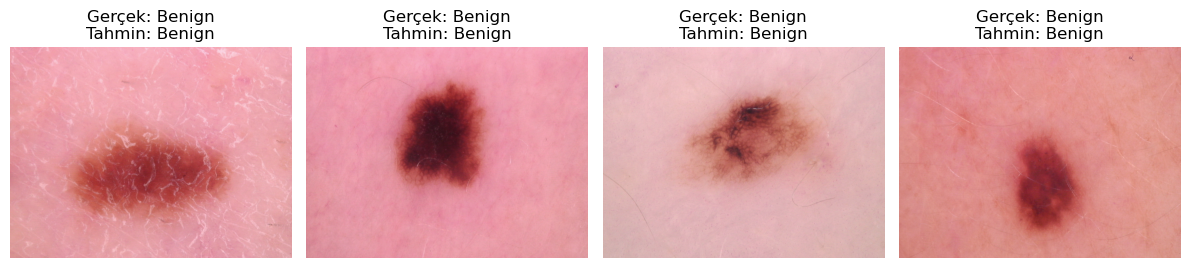

In [370]:
#ORTADAN SEÇİLEN 4 TEST ÖRNEĞİNİN GÖRSEL TAHMİN SONUÇLARI
plt.figure(figsize=(12,6))
model.eval()

for i, (img_path, true_label) in enumerate(middle_4_samples):
    image = Image.open(img_path).convert("RGB")
    input_tensor = val_test_transform(image).unsqueeze(0).to(device)
    
    #Tahmin
    outputs = model(input_tensor)
    _, pred_label = torch.max(outputs, 1)
    pred_label = pred_label.item()
    
    #Görselleştirme
    plt.subplot(1,4,i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Gerçek: {clinical_output(true_label)}\nTahmin: {clinical_output(pred_label)}")

plt.tight_layout()
plt.show()

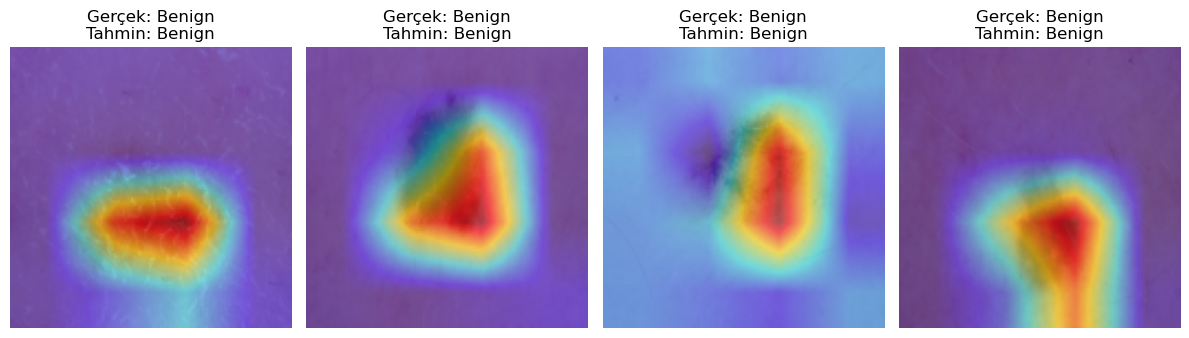

In [371]:
#ORTADAN SEÇİLEN 4 TEST ÖRNEĞİNİN GRAD-CAM GÖRSELLERİ
plt.figure(figsize=(12,6))
grad_cam = GradCAM(model, target_layer=model.features[-1])  # Grad-CAM sınıfı daha önce tanımlı olmalı
model.eval()

for i, (img_path, true_label) in enumerate(middle_4_samples):
    image = Image.open(img_path).convert("RGB")
    input_tensor = val_test_transform(image).unsqueeze(0).to(device)
    
    #Tahmin
    outputs = model(input_tensor)
    _, pred_label = torch.max(outputs, 1)
    pred_label = pred_label.item()
    
    #Grad-CAM maskesi
    cam = grad_cam.generate(input_tensor, class_idx=pred_label)
    cam = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    cam = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB)
    
    overlay = 0.5 * np.array(image.resize((cam.shape[1], cam.shape[0]))) + 0.5 * cam
    overlay = np.uint8(overlay)
    
    #Görselleştirme
    plt.subplot(1,4,i+1)
    plt.imshow(overlay)
    plt.axis('off')
    plt.title(f"Gerçek: {clinical_output(true_label)}\nTahmin: {clinical_output(pred_label)}")

plt.tight_layout()
plt.show()


In [372]:
#GERÇEK VE TAHMİN EDİLEN ETİKETLERİ NUMPY ARRAY’E ÇEVİRME
y_true = np.array(all_labels)
y_pred = np.array(all_preds)

In [373]:
#KANSER SINIFI İÇİN TP, FN VE FALSE NEGATIVE ORANI(FN RATE) HESAPLAMA
cancer_mask = np.isin(y_true, cancer_classes)
TP = np.sum(cancer_mask & np.isin(y_pred, cancer_classes))
FN = np.sum(cancer_mask & ~np.isin(y_pred, cancer_classes))
FN_rate = FN / (TP + FN) if (TP + FN) > 0 else 0

In [374]:
#KANSER SINIFI İÇİN TP,FN VE FN ORANI(FALSE NEGATIVE RATE) YAZDIRMA
print("Cancer TP (yakalanan):", TP)
print("Cancer FN (kaçırılan):", FN)
print("Cancer Kaçırma Oranı (FN Rate): {:.4f}".format(FN_rate))

Cancer TP (yakalanan): 311
Cancer FN (kaçırılan): 103
Cancer Kaçırma Oranı (FN Rate): 0.2488
